!!!!!!!README!!!!!!!!!!!!
i was having memory issue when i was using Binder , so i switched to Google Colab, so i dont have commited my results . but i experimented localy,also i deleted all the jovian related cells because i was having warnings . Thank you



# Classifying images of everyday objects using a neural network

The ability to try many different neural network architectures to address a problem is what makes deep learning really powerful, especially compared to shallow learning techniques like linear regression, logistic regression etc. 

In this assignment, you will:

1. Explore the CIFAR10 dataset: https://www.cs.toronto.edu/~kriz/cifar.html
2. Set up a training pipeline to train a neural network on a GPU
2. Experiment with different network architectures & hyperparameters

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end. Try to experiment with different network structures and hypeparameters to get the lowest loss.

You might find these notebooks useful for reference, as you work through this notebook:

- https://jovian.ml/aakashns/04-feedforward-nn
- https://jovian.ml/aakashns/fashion-feedforward-minimal

In [0]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pandas pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet

In [0]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [0]:
# Project name used for jovian.commit
project_name = '03-cifar10-feedforward'

## Exploring the CIFAR10 dataset

In [4]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

Files already downloaded and verified


**Q: How many images does the training dataset contain?**

In [5]:
dataset_size = len(dataset)
dataset_size

50000

**Q: How many images does the training dataset contain?**

In [6]:
test_dataset_size = len(test_dataset)
test_dataset_size

10000

**Q: How many output classes does the dataset contain? Can you list them?**

Hint: Use `dataset.classes`

In [7]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [8]:
num_classes = len(classes)
num_classes

10

**Q: What is the shape of an image tensor from the dataset?**

In [9]:
img, label = dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

Note that this dataset consists of 3-channel color images (RGB). Let us look at a sample image from the dataset. `matplotlib` expects channels to be the last dimension of the image tensors (whereas in PyTorch they are the first dimension), so we'll the `.permute` tensor method to shift channels to the last dimension. Let's also print the label for the image.

Label (numeric): 6
Label (textual): frog


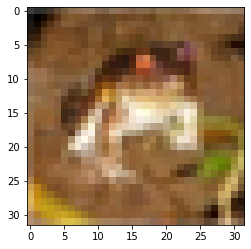

In [10]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

**(Optional) Q: Can you determine the number of images belonging to each class?**

Hint: Loop through the dataset.

Let's save our work to Jovian, before continuing.

In [0]:
!pip install jovian --upgrade --quiet

In [0]:
import jovian

In [13]:
jovian.commit(project=project_name, environment=None)

[jovian] Error: Failed to detect Jupyter notebook or Python script. Skipping..


## Preparing the data for training

We'll use a validation set with 5000 images (10% of the dataset). To ensure we get the same validation set each time, we'll set PyTorch's random number generator to a seed value of 43.

In [0]:
torch.manual_seed(43)
val_size = 5000
train_size = len(dataset) - val_size

Let's use the `random_split` method to create the training & validation sets

In [15]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

We can now create data loaders to load the data in batches.

In [0]:
batch_size=128

In [0]:
train_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(dataset, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(dataset, batch_size*2, num_workers=4, pin_memory=True)

Let's visualize a batch of data using the `make_grid` helper function from Torchvision.

images.shape: torch.Size([128, 3, 32, 32])


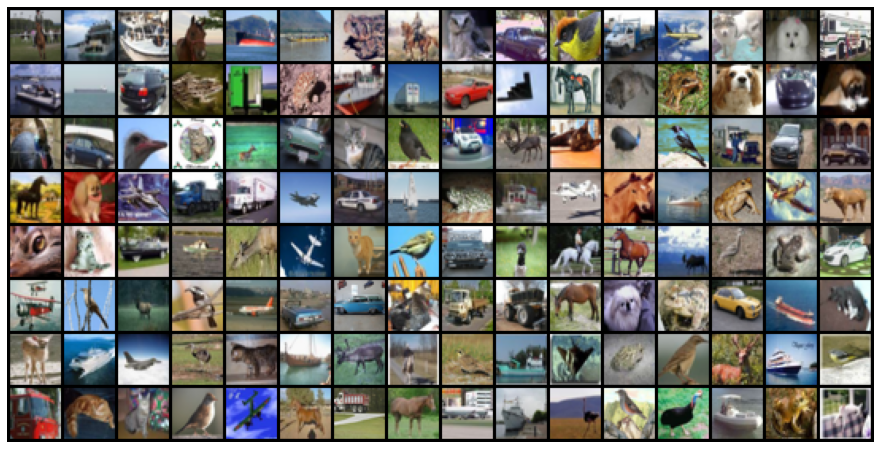

In [18]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

Can you label all the images by looking at them? Trying to label a random sample of the data manually is a good way to estimate the difficulty of the problem, and identify errors in labeling, if any.

## Base Model class & Training on GPU

Let's create a base model class, which contains everything except the model architecture i.e. it wil not contain the `__init__` and `__forward__` methods. We will later extend this class to try out different architectures. In fact, you can extend this model to solve any image classification problem.

In [0]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [0]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

We can also use the exact same training loop as before. I hope you're starting to see the benefits of refactoring our code into reusable functions.

In [0]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Finally, let's also define some utilities for moving out data & labels to the GPU, if one is available.

In [22]:
torch.cuda.is_available()

True

In [0]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [24]:
device = get_default_device()
device

device(type='cuda')

In [0]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Let us also define a couple of helper functions for plotting the losses & accuracies.

In [0]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [0]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

Let's move our data loaders to the appropriate device.

In [0]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## Training the model

We will make several attempts at training the model. Each time, try a different architecture and a different set of learning rates. Here are some ideas to try:
- Increase or decrease the number of hidden layers
- Increase of decrease the size of each hidden layer
- Try different activation functions
- Try training for different number of epochs
- Try different learning rates in every epoch

What's the highest validation accuracy you can get to? **Can you get to 50% accuracy? What about 60%?**

In [0]:
input_size = 3*32*32
output_size = 10


**Q: Extend the `ImageClassificationBase` class to complete the model definition.**

Hint: Define the `__init__` and `forward` methods.

In [0]:
class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 256)
        self.linear4 = nn.Linear(256, 128)
        self.linear5 = nn.Linear(128, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        out = self.linear1(out)
        out = F.relu(out)
        #out = F.dropout(out,0.5)
        out = self.linear2(out)
        out = F.relu(out)
        #out = F.dropout(out,0.5)
        out = self.linear3(out)
        out = F.relu(out)
       
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        return out

You can now instantiate the model, and move it the appropriate device.

In [0]:
model = to_device(CIFAR10Model(), device)

Before you train the model, it's a good idea to check the validation loss & accuracy with the initial set of weights.

In [32]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.10004384070634842, 'val_loss': 2.3040988445281982}]

**Q: Train the model using the `fit` function to reduce the validation loss & improve accuracy.**

Leverage the interactive nature of Jupyter to train the model in multiple phases, adjusting the no. of epochs & learning rate each time based on the result of the previous training phase.

In [33]:
history += fit(10, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9420, val_acc: 0.2736
Epoch [1], val_loss: 1.7986, val_acc: 0.3492
Epoch [2], val_loss: 1.7220, val_acc: 0.3776
Epoch [3], val_loss: 1.7726, val_acc: 0.3524
Epoch [4], val_loss: 1.6574, val_acc: 0.4085
Epoch [5], val_loss: 1.6966, val_acc: 0.3852
Epoch [6], val_loss: 1.5363, val_acc: 0.4472
Epoch [7], val_loss: 1.4894, val_acc: 0.4599
Epoch [8], val_loss: 1.4259, val_acc: 0.4861
Epoch [9], val_loss: 1.3744, val_acc: 0.5080


In [34]:
history += fit(10, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 1.2853, val_acc: 0.5417
Epoch [1], val_loss: 1.2659, val_acc: 0.5482
Epoch [2], val_loss: 1.2523, val_acc: 0.5544
Epoch [3], val_loss: 1.2457, val_acc: 0.5569
Epoch [4], val_loss: 1.2294, val_acc: 0.5631
Epoch [5], val_loss: 1.2243, val_acc: 0.5651
Epoch [6], val_loss: 1.2071, val_acc: 0.5713
Epoch [7], val_loss: 1.1965, val_acc: 0.5746
Epoch [8], val_loss: 1.1905, val_acc: 0.5786
Epoch [9], val_loss: 1.1728, val_acc: 0.5848


In [35]:
history += fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1622, val_acc: 0.5891
Epoch [1], val_loss: 1.1597, val_acc: 0.5900
Epoch [2], val_loss: 1.1581, val_acc: 0.5913
Epoch [3], val_loss: 1.1564, val_acc: 0.5908
Epoch [4], val_loss: 1.1546, val_acc: 0.5914
Epoch [5], val_loss: 1.1538, val_acc: 0.5927
Epoch [6], val_loss: 1.1523, val_acc: 0.5924
Epoch [7], val_loss: 1.1505, val_acc: 0.5937
Epoch [8], val_loss: 1.1490, val_acc: 0.5936
Epoch [9], val_loss: 1.1476, val_acc: 0.5945


In [36]:
history += fit(30, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1470, val_acc: 0.5945
Epoch [1], val_loss: 1.1468, val_acc: 0.5944
Epoch [2], val_loss: 1.1466, val_acc: 0.5946
Epoch [3], val_loss: 1.1464, val_acc: 0.5949
Epoch [4], val_loss: 1.1463, val_acc: 0.5948
Epoch [5], val_loss: 1.1461, val_acc: 0.5949
Epoch [6], val_loss: 1.1460, val_acc: 0.5950
Epoch [7], val_loss: 1.1458, val_acc: 0.5952
Epoch [8], val_loss: 1.1457, val_acc: 0.5952
Epoch [9], val_loss: 1.1455, val_acc: 0.5953
Epoch [10], val_loss: 1.1454, val_acc: 0.5951
Epoch [11], val_loss: 1.1452, val_acc: 0.5954
Epoch [12], val_loss: 1.1451, val_acc: 0.5953
Epoch [13], val_loss: 1.1449, val_acc: 0.5954
Epoch [14], val_loss: 1.1448, val_acc: 0.5952
Epoch [15], val_loss: 1.1446, val_acc: 0.5955
Epoch [16], val_loss: 1.1445, val_acc: 0.5952
Epoch [17], val_loss: 1.1443, val_acc: 0.5956
Epoch [18], val_loss: 1.1442, val_acc: 0.5951
Epoch [19], val_loss: 1.1441, val_acc: 0.5952
Epoch [20], val_loss: 1.1439, val_acc: 0.5955
Epoch [21], val_loss: 1.1438, val_acc: 0.595

Plot the losses and the accuracies to check if you're starting to hit the limits of how well your model can perform on this dataset. You can train some more if you can see the scope for further improvement.

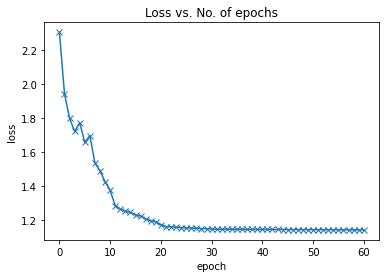

In [37]:
plot_losses(history)

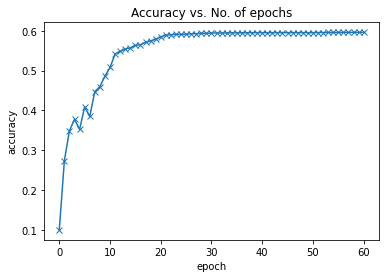

In [38]:
plot_accuracies(history)

Finally, evaluate the model on the test dataset report its final performance.

In [39]:
evaluate(model, test_loader)

{'val_acc': 0.5963448286056519, 'val_loss': 1.1425902843475342}

Are you happy with the accuracy? Record your results by completing the section below, then you can come back and try a different architecture & hyperparameters.

## Recoding your results

As your perform multiple experiments, it's important to record the results in a systematic fashion, so that you can review them later and identify the best approaches that you might want to reproduce or build upon later. 

**Q: Describe the model's architecture with a short summary.**

E.g. `"3 layers (16,32,10)"` (16, 32 and 10 represent output sizes of each layer)

In [0]:
arch = (1024,512,256,128,10)

**Q: Provide the list of learning rates used while training.**

In [0]:
lrs = [0.1,0.01,0.001,0.0001]

**Q: Provide the list of no. of epochs used while training.**

In [0]:
epochs = [10,10,20,30]

**Q: What were the final test accuracy & test loss?**

In [0]:
test_acc = 0.5963448286056519
test_loss = 1.1425902843475342